In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
seed = 10599
aqua_globals.random_seed = seed

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [12]:
dataset = np.genfromtxt("breastcancerdata2.csv", delimiter=',', skip_header=2, max_rows = 100)
dataset

array([[8.4230200e+05,           nan, 1.0000000e+00, ..., 2.6540000e-01,
        4.6010000e-01, 1.1890000e-01],
       [8.4251700e+05,           nan, 1.0000000e+00, ..., 1.8600000e-01,
        2.7500000e-01, 8.9020000e-02],
       [8.4300903e+07,           nan, 1.0000000e+00, ..., 2.4300000e-01,
        3.6130000e-01, 8.7580000e-02],
       ...,
       [8.6226100e+05,           nan, 0.0000000e+00, ..., 2.3810000e-02,
        1.9340000e-01, 8.9880000e-02],
       [8.6248500e+05,           nan, 0.0000000e+00, ..., 8.4490000e-02,
        2.7720000e-01, 8.7560000e-02],
       [8.6254800e+05,           nan, 1.0000000e+00, ..., 1.5650000e-01,
        2.7180000e-01, 9.3530000e-02]])

In [13]:
# split dataset 
X = dataset[:, 3:33]
y = dataset[:, 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

#apply feature scaling
sc = StandardScaler()
  
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train)
# 
pca = PCA(n_components = 4)
  
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
  
explained_variance = pca.explained_variance_ratio_

[[-0.69465541 -0.9753037  -0.62603035 ...  0.30667791  0.80408888
   1.53851195]
 [ 1.39138946  0.46452563  1.34924487 ...  1.27399021  0.3790285
  -0.19527466]
 [ 1.81493725  0.92890302  1.6490969  ...  0.68293291 -0.52479613
  -0.77540098]
 ...
 [ 0.34836702  0.0494397   0.2706105  ... -0.00359207 -0.72132942
  -1.3117353 ]
 [ 0.12650866  1.50742904  0.19981211 ...  0.70399196  0.85207956
   0.33117114]
 [-0.12704375  0.08057114 -0.13002512 ...  0.05958507 -0.64363021
   0.08489998]]


In [14]:
training_input = {
    "B": [],
    "M": []
}
test_input = {
    "B": [],
    "M": []
}

for i in range(len(X_train)):
    if y_train[i] == 1:
        training_input["M"].append(X_train[i])
    else:
        training_input["B"].append(X_train[i])
        
for i in range(len(X_test)):
    if y_test[i] == 1:
        test_input["M"].append(X_test[i])
    else:
        test_input["B"].append(X_test[i])


In [5]:
#feature maps
feature_map = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear') #ZZ
#feature_map = ZFeatureMap(feature_dimension=4, reps = 1) #Z
#feature_map = PauliFeatureMap(feature_dimension=4, reps=1, entanglement='linear', paulis=['Y', 'Z']) #Pauli

feature_map.draw()

┌───┐┌─────────────┐                                               »
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■───────»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐     »
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──■──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     └───┘└─────────────┘                                          └───┘»
«                                          
«q_0: ─────────────────────────────────────
«                                          
«q_1: ──────────────────────────────────■──
«     ┌──────────────────────────────┐┌─┴─┐
«q_2: ┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├
«     └──────────────────────────────┘└───┘

Testing success ratio: 0.5333333333333333
158.54360222816467


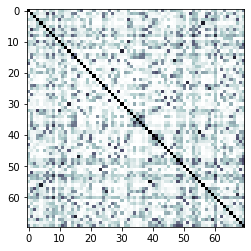

In [18]:
#one time
start = time.time()
qsvm = QSVM(feature_map, training_input, test_input)
backend = BasicAer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')

#kernel matrix 
kernel_matrix = result['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r');
end = time.time()
print(end - start)

In [29]:
#calculate precision recall accuracy f1-score
truepos = 0
falsepos = 0
trueneg = 0
falseneg = 0


res = qsvm.predict(np.array(X_test), quantum_instance)
total = len(res)
for i in range(total):
    if y_test[i]==1:
        if res[i]==1:
            truepos+=1
        else:
            falseneg+=1
    else:
        if res[i]==0:
            trueneg+=1
        else:
            falsepos+=1

precision = truepos/(truepos+falsepos)
recall = truepos/(truepos+falseneg)
print("accuracy: ", (truepos+trueneg)/total)
print("precision: ", precision)
print("recall: ", recall)
print("f1-score: ", 2*precision*recall/(precision+recall))

accuracy:  0.36666666666666664
precision:  0.4375
recall:  0.4117647058823529
f1-score:  0.42424242424242425


In [28]:
qsvm = QSVM(feature_map, training_input, test_input)
backend = BasicAer.get_backend('qasm_simulator')

#accuracy as a function of shots
shots = []
accuracy = []

for i in range(500, 3000, 500):
    start = time.time()
    quantum_instance = QuantumInstance(backend, shots=i, seed_simulator=seed, seed_transpiler=seed)
    result = qsvm.run(quantum_instance)
    shots.append(i)
    accuracy.append(result["testing_accuracy"])
    print(i, end = " done \n")
    end = time.time()
    print(end - start, end = " sec elapsed \n")
    print("testing accuracy = ", result["testing_accuracy"])

plt.plot(shots, accuracy)

500 done 
150.45099782943726 sec elapsed 
testing accuracy =  0.3
1000 done 
163.04139494895935 sec elapsed 
testing accuracy =  0.3333333333333333
1500 done 
168.8295738697052 sec elapsed 
testing accuracy =  0.3
2000 done 
171.8450140953064 sec elapsed 
testing accuracy =  0.3333333333333333


QiskitError: 'Keyboard interrupt in parallel_map.'

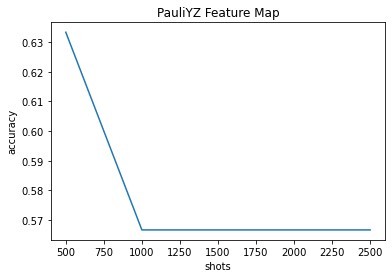

In [37]:
#plot, label, and save
plt.plot(shots, accuracy)
plt.xlabel("shots")
plt.ylabel("accuracy")
plt.title("PauliYZ Feature Map")
plt.savefig('PauliYZFeatureMap_accuracy.png')

Testing success ratio: 0.9

accuracy:  0.9
precision:  0.9444444444444444
recall:  0.8947368421052632
f1-score:  0.918918918918919


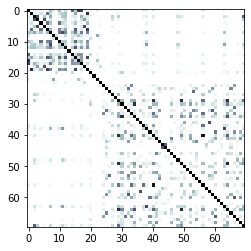

In [16]:
#classical SVM
from qiskit.aqua.algorithms import SklearnSVM

svm = SklearnSVM(training_input, test_input)
result = svm.run()

print(f'Testing success ratio: {result["testing_accuracy"]}')
print()

kernel_matrix = result['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r');

truepos = 0
falsepos = 0
trueneg = 0
falseneg = 0

res = svm.predict(np.array(X_test))
total = len(res)
for i in range(total):
    if y_test[i]==1:
        if res[i]==1:
            truepos+=1
        else:
            falseneg+=1
    else:
        if res[i]==0:
            trueneg+=1
        else:
            falsepos+=1

precision = truepos/(truepos+falsepos)
recall = truepos/(truepos+falseneg)
print("accuracy: ", (truepos+trueneg)/total)
print("precision: ", precision)
print("recall: ", recall)
print("f1-score: ", 2*precision*recall/(precision+recall))

In [34]:
backend = BasicAer.get_backend('qasm_simulator')


# # trial 1
# start = time.time()
# feature_map = PauliFeatureMap(feature_dimension=4, reps=1, entanglement='linear', paulis=['X', 'Z']) #Pauli
# qsvm = QSVM(feature_map, training_input, test_input)
# quantum_instance = QuantumInstance(backend, shots=500, seed_simulator=seed, seed_transpiler=seed)
# result = qsvm.run(quantum_instance)
# print("Feature Map: ", "Pauli X Z")
# print(f'Testing success ratio: {result["testing_accuracy"]}')
# end = time.time()
# print("Elapsed time: ", end-start)
# print()

# # trial 2
# start = time.time()
# feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear')
# qsvm = QSVM(feature_map, training_input, test_input)
# quantum_instance = QuantumInstance(backend, shots=500, seed_simulator=seed, seed_transpiler=seed)
# result = qsvm.run(quantum_instance)
# print("Feature Map: ", "ZZ rep 2")
# print(f'Testing success ratio: {result["testing_accuracy"]}')
# end = time.time()
# print("Elapsed time: ", end-start)
# print()

# # trial 3
# start = time.time()
# feature_map = ZFeatureMap(feature_dimension=4, reps = 2)
# qsvm = QSVM(feature_map, training_input, test_input)
# quantum_instance = QuantumInstance(backend, shots=500, seed_simulator=seed, seed_transpiler=seed)
# result = qsvm.run(quantum_instance)
# print("Feature Map: ", "Z rep 2")
# print(f'Testing success ratio: {result["testing_accuracy"]}')
# end = time.time()
# print("Elapsed time: ", end-start)
# print()

# # trial 4 
# start = time.time()
# feature_map = PauliFeatureMap(feature_dimension=4, reps=1, entanglement='linear', paulis=['Y', 'Z']) #Pauli
# qsvm = QSVM(feature_map, training_input, test_input)
# quantum_instance = QuantumInstance(backend, shots=500, seed_simulator=seed, seed_transpiler=seed)
# result = qsvm.run(quantum_instance)
# print("Feature Map: ", "Pauli Y Z")
# print(f'Testing success ratio: {result["testing_accuracy"]}')
# end = time.time()
# print("Elapsed time: ", end-start)
# print()

# trial 5
start = time.time()
feature_map = PauliFeatureMap(feature_dimension=4, reps=1, entanglement='linear', paulis=['X', 'Y']) #Pauli
qsvm = QSVM(feature_map, training_input, test_input)
quantum_instance = QuantumInstance(backend, shots=500, seed_simulator=seed, seed_transpiler=seed)
result = qsvm.run(quantum_instance)
print("Feature Map: ", "Pauli X X")
print(f'Testing success ratio: {result["testing_accuracy"]}')
end = time.time()
print("Elapsed time: ", end-start)
print()

# trial 6
start = time.time()
feature_map = PauliFeatureMap(feature_dimension=4, reps=1, entanglement='linear', paulis=['Y', 'Y']) #Pauli
qsvm = QSVM(feature_map, training_input, test_input)
quantum_instance = QuantumInstance(backend, shots=500, seed_simulator=seed, seed_transpiler=seed)
result = qsvm.run(quantum_instance)
print("Feature Map: ", "Pauli Y Y")
print(f'Testing success ratio: {result["testing_accuracy"]}')
end = time.time()
print("Elapsed time: ", end-start)
print()

# trial 7
start = time.time()
feature_map = PauliFeatureMap(feature_dimension=4, reps=1, entanglement='linear', paulis=['X', 'Z']) #Pauli
qsvm = QSVM(feature_map, training_input, test_input)
quantum_instance = QuantumInstance(backend, shots=500, seed_simulator=seed, seed_transpiler=seed)
result = qsvm.run(quantum_instance)
print("Feature Map: ", "Pauli X Z")
print(f'Testing success ratio: {result["testing_accuracy"]}')
end = time.time()
print("Elapsed time: ", end-start)
print()


Feature Map:  Pauli X X
Testing success ratio: 0.6
Elapsed time:  137.6202929019928

Feature Map:  Pauli Y Y
Testing success ratio: 0.5666666666666667
Elapsed time:  147.35796928405762

Feature Map:  Pauli X Z
Testing success ratio: 0.6
Elapsed time:  161.55026483535767



In [ ]:
#Results

#####
EXP 1: 
shot = 500 and sample size = 100
classical accuracy = 0.86667

Feature Map:  Pauli X Z
Testing success ratio: 0.6
Elapsed time:  138.0393042564392

Feature Map:  ZZ rep 2
Testing success ratio: 0.43333333333333335
Elapsed time:  203.25862407684326

Feature Map:  Z rep 2
Testing success ratio: 0.5333333333333333
Elapsed time:  142.4100799560547

Feature Map:  Pauli Y Z
Testing success ratio: 0.6333333333333333
Elapsed time:  153.7728168964386

Feature Map:  Pauli X X
Testing success ratio: 0.6
Elapsed time:  137.6202929019928

Feature Map:  Pauli Y Y
Testing success ratio: 0.5666666666666667
Elapsed time:  147.35796928405762

Feature Map:  Pauli X Z
Testing success ratio: 0.6
Elapsed time:  161.55026483535767
#####